In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Setting
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries berhasil diimport!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ Libraries berhasil diimport!
NumPy version: 2.0.2
Pandas version: 2.2.2


In [2]:
import os
import tarfile
import urllib.request

# Download data
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """Download dan extract housing dataset"""
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    print("✓ Data berhasil didownload dan diekstrak!")

def load_housing_data(housing_path=HOUSING_PATH):
    """Load housing data sebagai pandas DataFrame"""
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Download dan load data
fetch_housing_data()
housing = load_housing_data()

print(f"\n✓ Dataset loaded! Shape: {housing.shape}")
print(f"  Rows: {housing.shape[0]:,}")
print(f"  Columns: {housing.shape[1]}")

✓ Data berhasil didownload dan diekstrak!

✓ Dataset loaded! Shape: (20640, 10)
  Rows: 20,640
  Columns: 10


In [3]:
# Melihat 5 baris pertama
print("=" * 80)
print("TOP 5 ROWS")
print("=" * 80)
print(housing.head())

print("\n" + "=" * 80)
print("DATA INFO")
print("=" * 80)
print(housing.info())

print("\n" + "=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)
print(housing.describe())

TOP 5 ROWS
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  

DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206

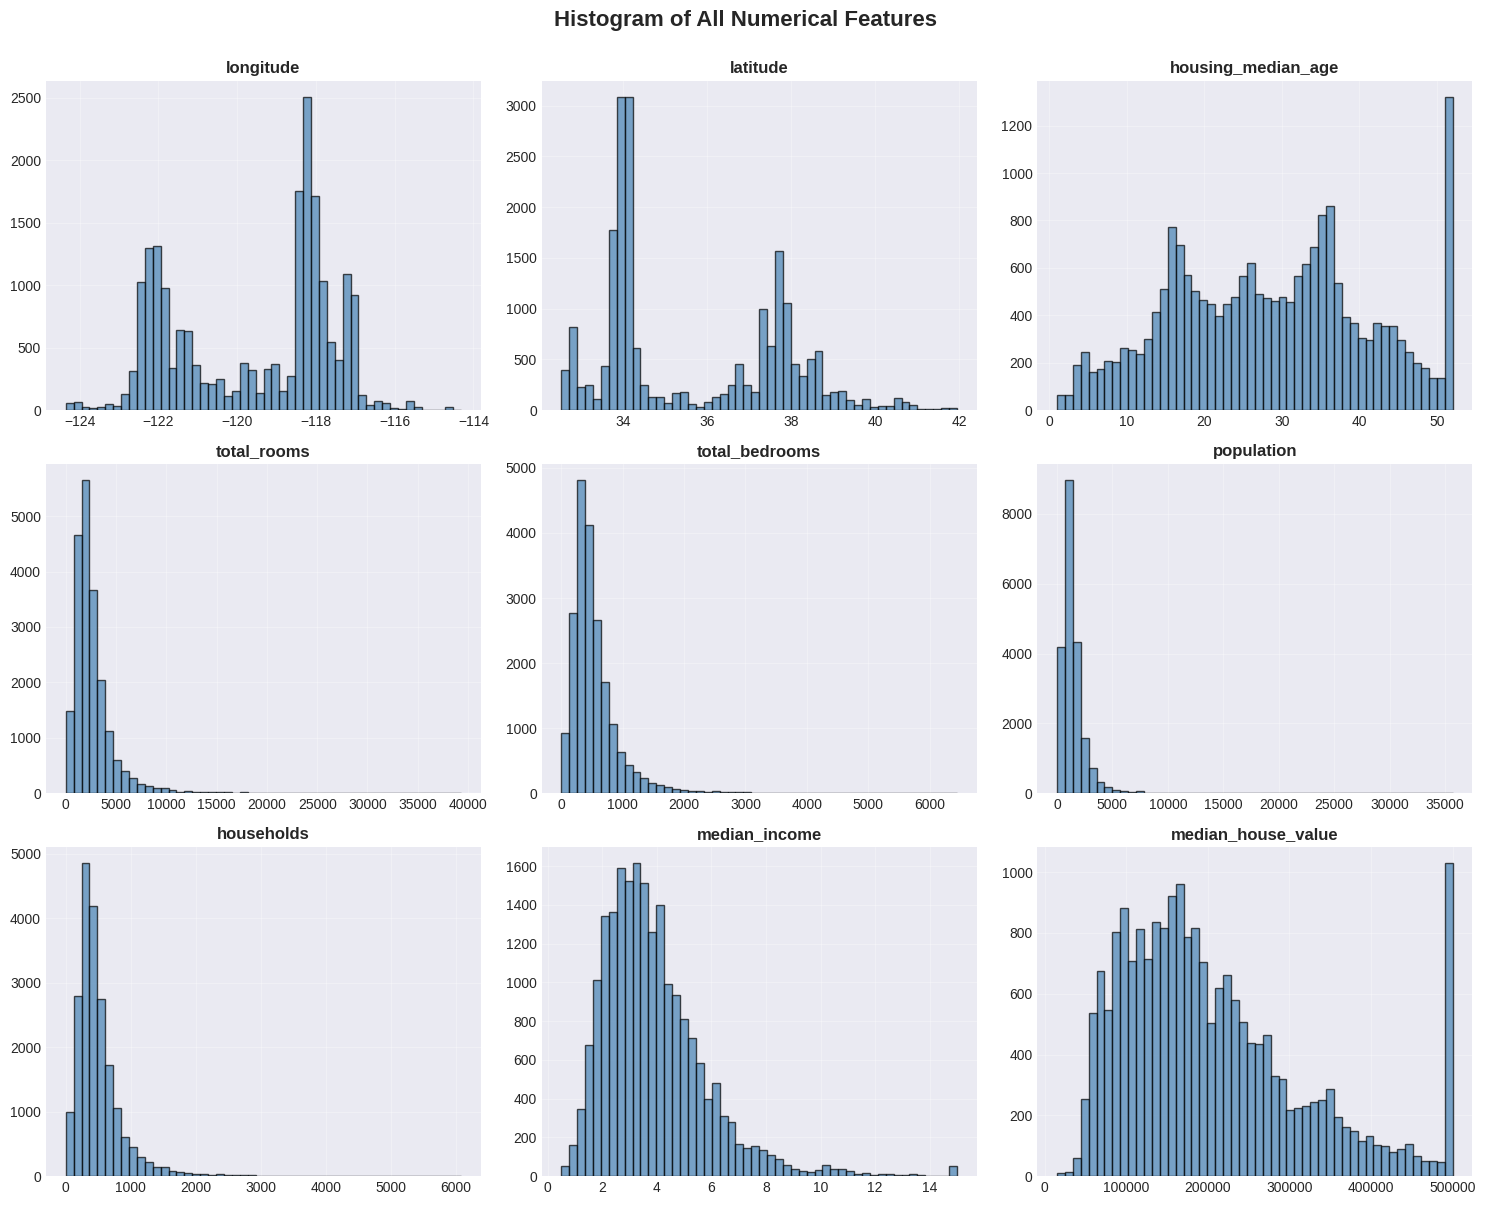


📊 Key Observations:
1. median_income: Scaled, capped at 15
2. housing_median_age & median_house_value: Capped values
3. Different scales: Need feature scaling
4. Tail-heavy distributions: May need transformation


In [4]:
# Histogram untuk semua numerical attributes
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Histogram of All Numerical Features', fontsize=16, fontweight='bold', y=1.00)

for idx, col in enumerate(housing.select_dtypes(include=[np.number]).columns):
    row = idx // 3
    col_idx = idx % 3
    ax = axes[row, col_idx]

    housing[col].hist(bins=50, ax=ax, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_title(col, fontweight='bold')
    ax.set_xlabel('')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("1. median_income: Scaled, capped at 15")
print("2. housing_median_age & median_house_value: Capped values")
print("3. Different scales: Need feature scaling")
print("4. Tail-heavy distributions: May need transformation")

OCEAN PROXIMITY VALUE COUNTS
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


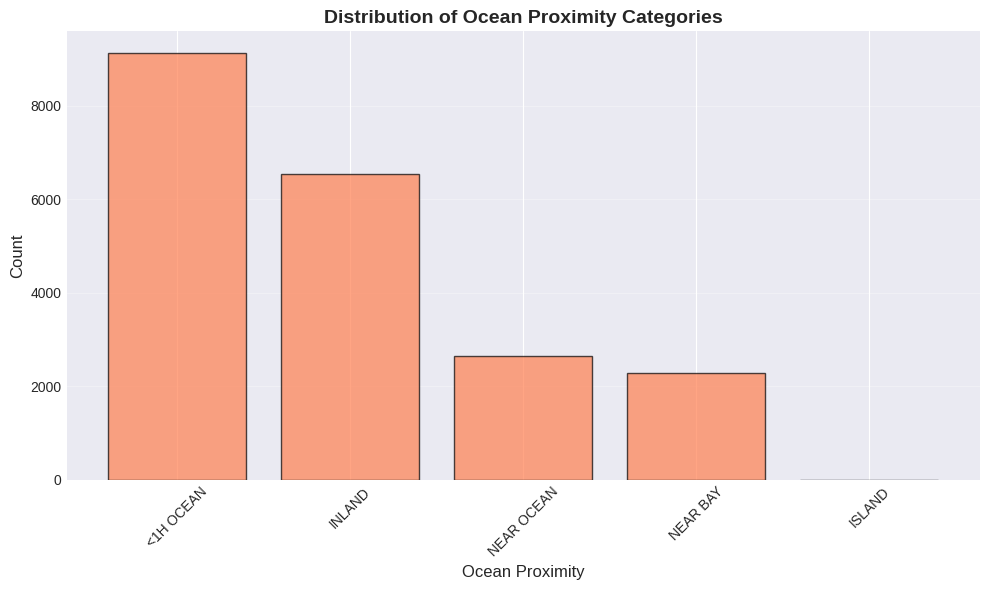

In [5]:
# Analisis ocean_proximity (categorical feature)
print("=" * 80)
print("OCEAN PROXIMITY VALUE COUNTS")
print("=" * 80)
print(housing["ocean_proximity"].value_counts())

# Visualisasi
plt.figure(figsize=(10, 6))
ocean_counts = housing["ocean_proximity"].value_counts()
plt.bar(ocean_counts.index, ocean_counts.values, color='coral', edgecolor='black', alpha=0.7)
plt.title('Distribution of Ocean Proximity Categories', fontsize=14, fontweight='bold')
plt.xlabel('Ocean Proximity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

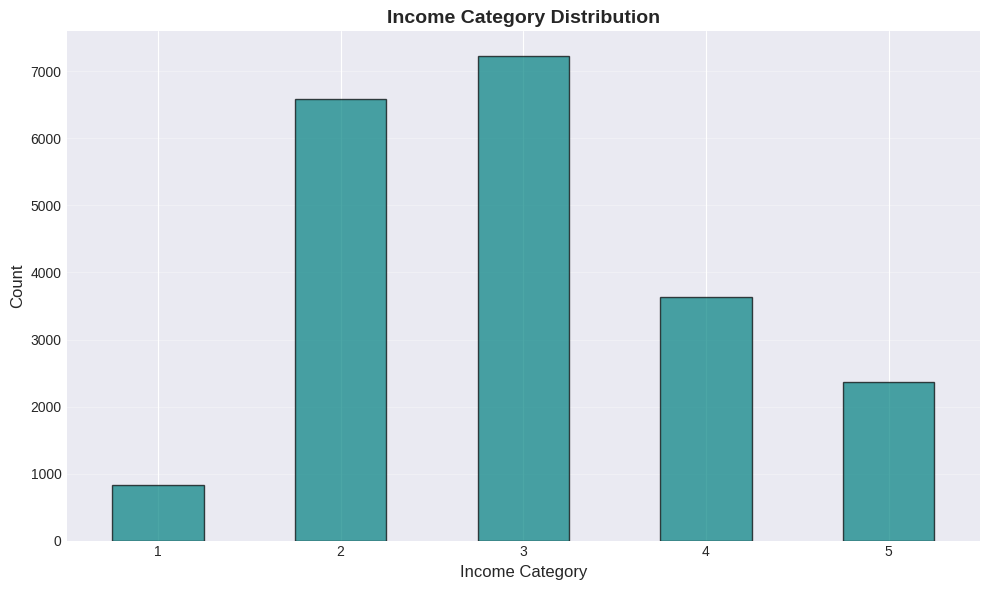

✓ Train/Test split completed!
  Training set: 16,512 samples
  Test set: 4,128 samples
  Test ratio: 20.0%


In [6]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# Membuat income categories untuk stratified sampling
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# Visualisasi income categories
plt.figure(figsize=(10, 6))
housing["income_cat"].value_counts().sort_index().plot(kind='bar', color='teal', edgecolor='black', alpha=0.7)
plt.title('Income Category Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Income Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Hapus income_cat
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

print("✓ Train/Test split completed!")
print(f"  Training set: {len(strat_train_set):,} samples")
print(f"  Test set: {len(strat_test_set):,} samples")
print(f"  Test ratio: {len(strat_test_set)/len(housing)*100:.1f}%")

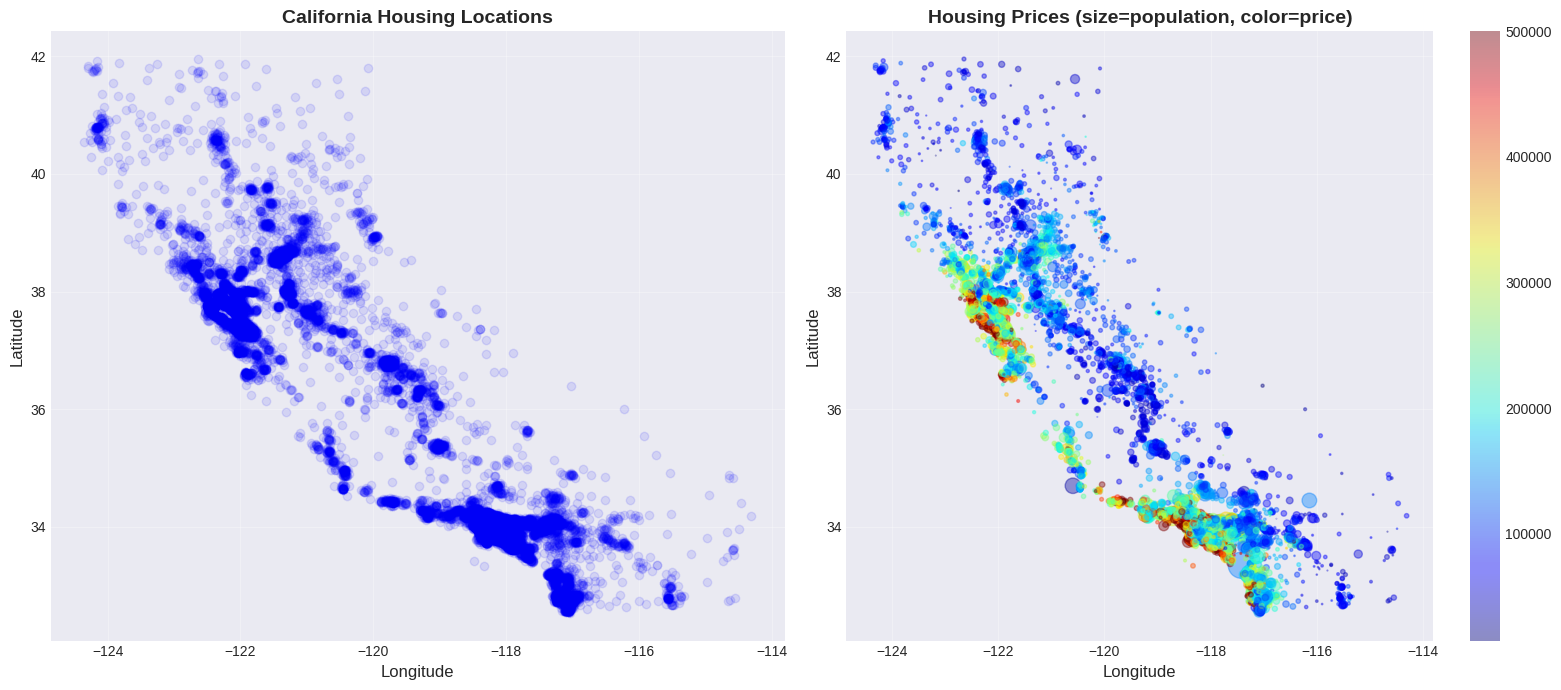


📍 Geographic Insights:
1. High density areas: Bay Area, LA, San Diego
2. Coastal areas generally more expensive (except Northern CA)
3. Population correlates with housing prices


In [8]:
# Create copy untuk exploration
housing = strat_train_set.copy()

# Plot 1: Simple scatter
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Simple scatter
axes[0].scatter(housing["longitude"], housing["latitude"], alpha=0.1, c='blue')
axes[0].set_xlabel('Longitude', fontsize=12)
axes[0].set_ylabel('Latitude', fontsize=12)
axes[0].set_title('California Housing Locations', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Enhanced scatter dengan density
scatter = axes[1].scatter(housing["longitude"], housing["latitude"], alpha=0.4,
               s=housing["population"]/100, c=housing["median_house_value"],
               cmap='jet')  # Removed colorbar=True from scatter
axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].set_title('Housing Prices (size=population, color=price)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add colorbar
fig.colorbar(scatter, ax=axes[1])

plt.tight_layout()
plt.show()

print("\n📍 Geographic Insights:")
print("1. High density areas: Bay Area, LA, San Diego")
print("2. Coastal areas generally more expensive (except Northern CA)")
print("3. Population correlates with housing prices")

CORRELATION WITH MEDIAN HOUSE VALUE
median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


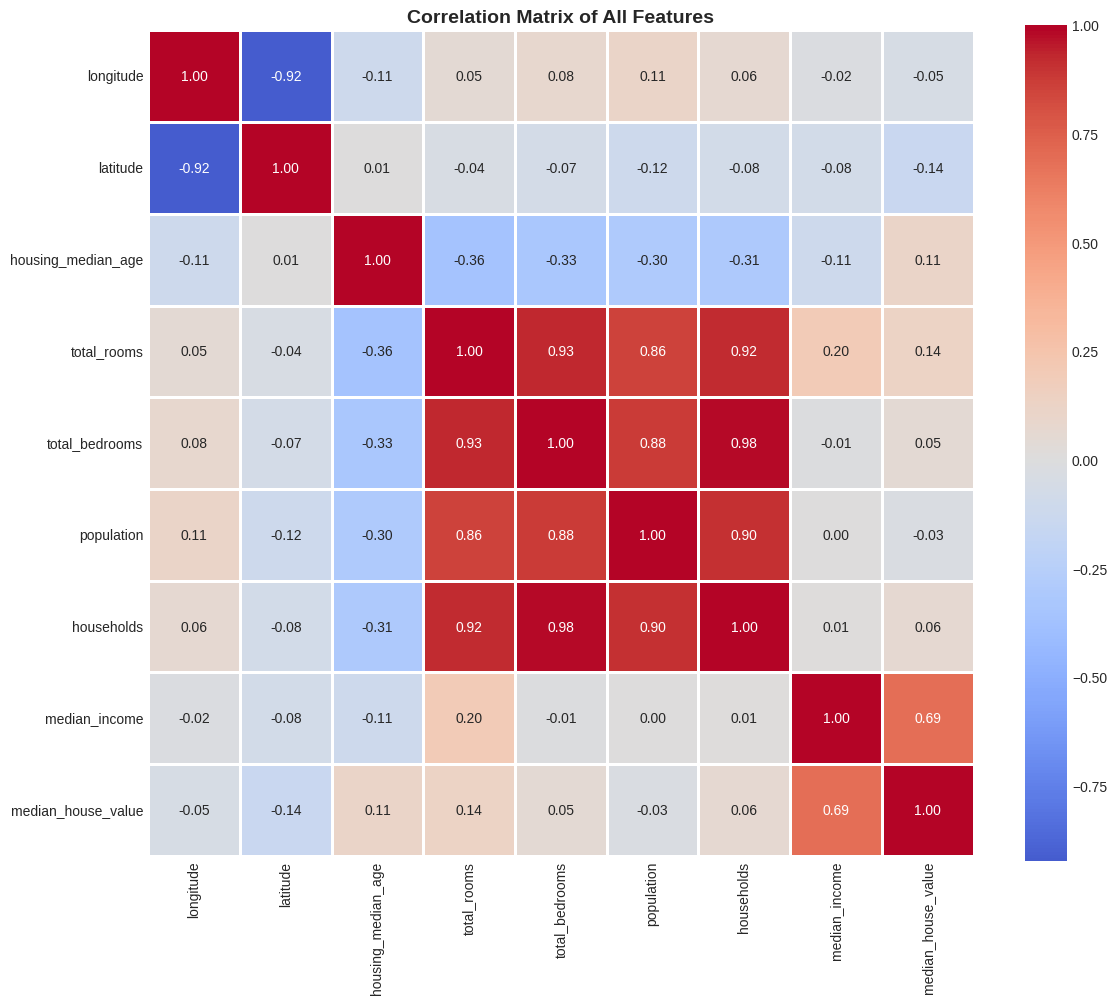

In [10]:
# Correlation matrix
corr_matrix = housing.drop("ocean_proximity", axis=1).corr()

# Korelasi dengan median_house_value
print("=" * 80)
print("CORRELATION WITH MEDIAN HOUSE VALUE")
print("=" * 80)
print(corr_matrix["median_house_value"].sort_values(ascending=False))

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, fmt='.2f')
plt.title('Correlation Matrix of All Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

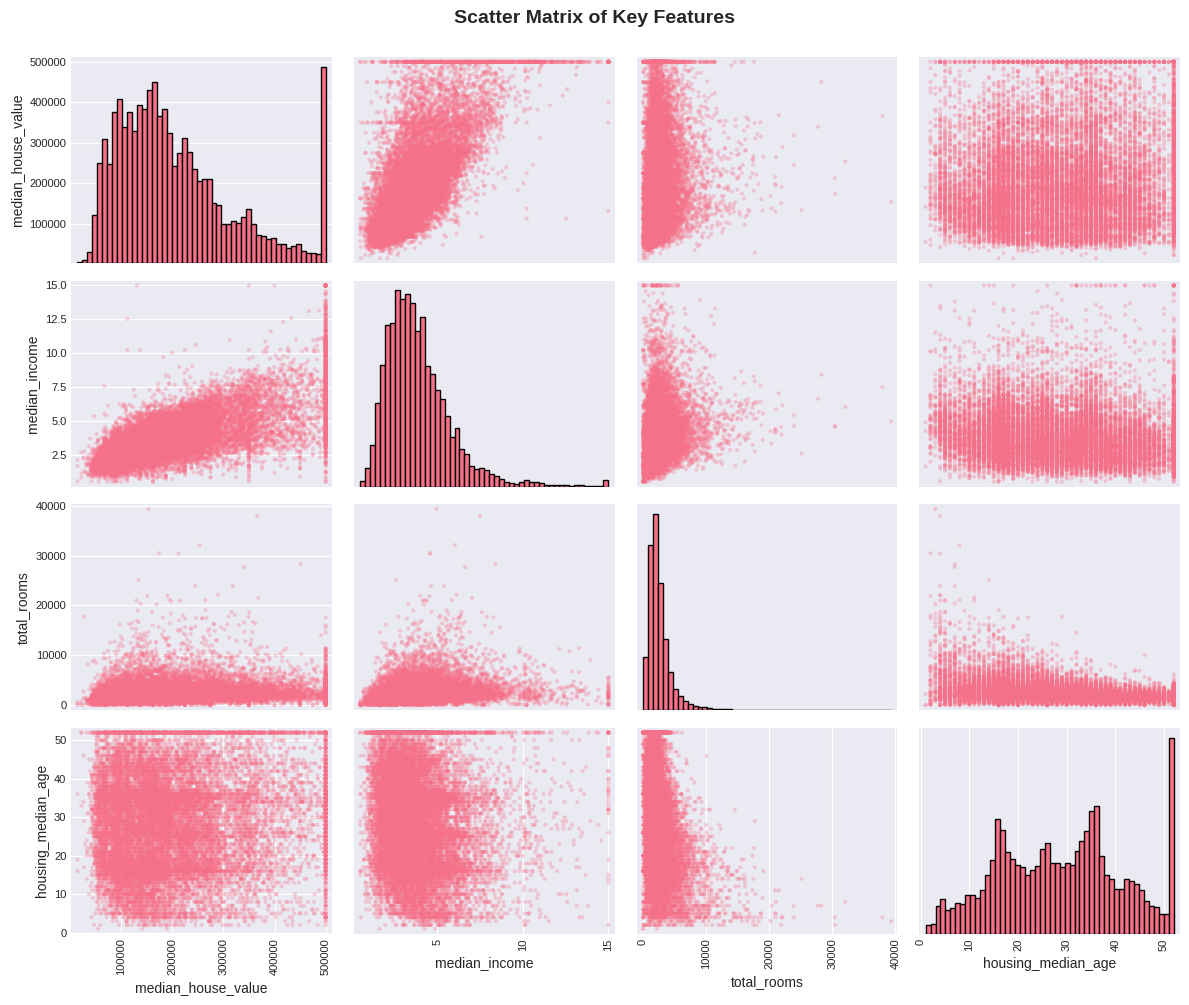

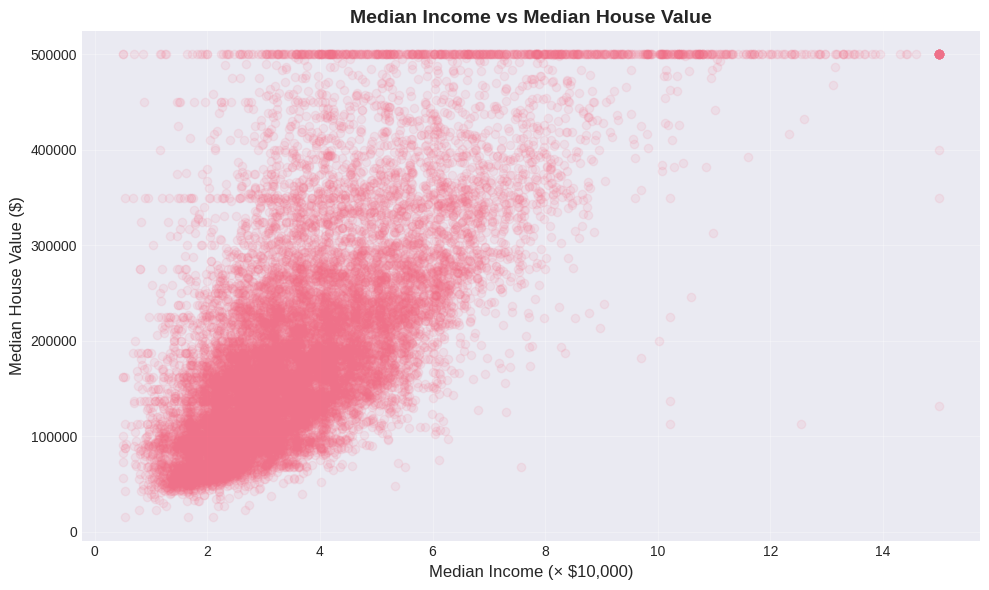


🔍 Correlation Insights:
1. median_income: Strongest correlation (0.69)
2. Clear upward trend visible
3. Price caps visible at $500k, $450k, $350k


In [11]:
from pandas.plotting import scatter_matrix

# Pilih attributes yang paling berkorelasi
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

# Scatter matrix
scatter_matrix(housing[attributes], figsize=(12, 10), alpha=0.3,
              diagonal='hist', hist_kwds={'bins': 50, 'edgecolor': 'black'})
plt.suptitle('Scatter Matrix of Key Features', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Zoom in: median_income vs median_house_value
plt.figure(figsize=(10, 6))
plt.scatter(housing["median_income"], housing["median_house_value"], alpha=0.1)
plt.xlabel('Median Income (× $10,000)', fontsize=12)
plt.ylabel('Median House Value ($)', fontsize=12)
plt.title('Median Income vs Median House Value', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🔍 Correlation Insights:")
print("1. median_income: Strongest correlation (0.69)")
print("2. Clear upward trend visible")
print("3. Price caps visible at $500k, $450k, $350k")

In [13]:
# Membuat kombinasi attributes baru
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

# Cek korelasi baru
corr_matrix_new = housing.drop("ocean_proximity", axis=1).corr()
print("=" * 80)
print("CORRELATION WITH NEW FEATURES")
print("=" * 80)
print(corr_matrix_new["median_house_value"].sort_values(ascending=False))

print("\n✨ Feature Engineering Results:")
print("1. bedrooms_per_room: Strong negative correlation (-0.26)")
print("2. rooms_per_household: Better than total_rooms (0.15 vs 0.13)")
print("3. Lower bedroom/room ratio → More expensive houses")

CORRELATION WITH NEW FEATURES
median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

✨ Feature Engineering Results:
1. bedrooms_per_room: Strong negative correlation (-0.26)
2. rooms_per_household: Better than total_rooms (0.15 vs 0.13)
3. Lower bedroom/room ratio → More expensive houses


In [14]:
# Revert to clean training set
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

print("✓ Data preparation started!")
print(f"  Features shape: {housing.shape}")
print(f"  Labels shape: {housing_labels.shape}")
print(f"\nMissing values:")
print(housing.isnull().sum()[housing.isnull().sum() > 0])

✓ Data preparation started!
  Features shape: (16512, 9)
  Labels shape: (16512,)

Missing values:
total_bedrooms    158
dtype: int64


In [15]:
from sklearn.impute import SimpleImputer

# Separate numerical dan categorical
housing_num = housing.drop("ocean_proximity", axis=1)
housing_cat = housing[["ocean_proximity"]]

# Imputer untuk missing values
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)

print("=" * 80)
print("IMPUTER STATISTICS (Medians)")
print("=" * 80)
for col, median in zip(housing_num.columns, imputer.statistics_):
    print(f"{col:25s}: {median:>12.2f}")

# Transform data
X = imputer.transform(housing_num)
housing_num_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

print("\n✓ Missing values handled!")
print(f"  Missing values after imputation: {housing_num_tr.isnull().sum().sum()}")

IMPUTER STATISTICS (Medians)
longitude                :      -118.51
latitude                 :        34.26
housing_median_age       :        29.00
total_rooms              :      2119.00
total_bedrooms           :       433.00
population               :      1164.00
households               :       408.00
median_income            :         3.54

✓ Missing values handled!
  Missing values after imputation: 0


In [17]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Method 1: Ordinal Encoding
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

print("=" * 80)
print("ORDINAL ENCODING")
print("=" * 80)
print(f"Original categories: {ordinal_encoder.categories_[0]}")
print(f"Encoded values (first 10): {housing_cat_encoded[:10].ravel()}")

# Method 2: One-Hot Encoding (RECOMMENDED)
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

print("\n" + "=" * 80)
print("ONE-HOT ENCODING")
print("=" * 80)
print(f"Categories: {cat_encoder.categories_[0]}")
print(f"Output shape: {housing_cat_1hot.shape}")
print(f"First 5 rows:\n{housing_cat_1hot[:5]}")

print("\n✓ Categorical encoding completed!")

ORDINAL ENCODING
Original categories: ['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']
Encoded values (first 10): [1. 4. 1. 4. 0. 3. 0. 0. 0. 0.]

ONE-HOT ENCODING
Categories: ['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']
Output shape: (16512, 5)
First 5 rows:
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]

✓ Categorical encoding completed!


In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

# Indices kolom
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    """Custom transformer untuk menambahkan attribute combinations"""

    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# Test custom transformer
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.transform(housing_num.values)

print("✓ Custom transformer created!")
print(f"  Original features: {housing_num.shape[1]}")
print(f"  With new features: {housing_extra_attribs.shape[1]}")
print(f"  New features added: {housing_extra_attribs.shape[1] - housing_num.shape[1]}")

✓ Custom transformer created!
  Original features: 8
  With new features: 11
  New features added: 3


In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Contoh data untuk demonstrasi
sample_data = housing_num.iloc[:5].copy()

print("=" * 80)
print("ORIGINAL DATA (First 5 samples)")
print("=" * 80)
print(sample_data[['total_rooms', 'median_income']].round(2))

# StandardScaler (Standardization)
std_scaler = StandardScaler()
standardized = std_scaler.fit_transform(sample_data)

print("\n" + "=" * 80)
print("AFTER STANDARDIZATION (mean=0, std=1)")
print("=" * 80)
print(pd.DataFrame(standardized,
                   columns=sample_data.columns)[['total_rooms', 'median_income']].round(2))

# MinMaxScaler (Normalization)
minmax_scaler = MinMaxScaler()
normalized = minmax_scaler.fit_transform(sample_data)

print("\n" + "=" * 80)
print("AFTER NORMALIZATION (range 0-1)")
print("=" * 80)
print(pd.DataFrame(normalized,
                   columns=sample_data.columns)[['total_rooms', 'median_income']].round(2))

print("\n📐 Feature Scaling:")
print("• StandardScaler: Removes mean, scales to unit variance")
print("• MinMaxScaler: Scales to [0, 1] range")
print("• Choice depends on algorithm and data distribution")

ORIGINAL DATA (First 5 samples)
       total_rooms  median_income
12655       3873.0           2.17
15502       5320.0           6.34
2908        1618.0           2.88
14053       1877.0           2.23
20496       3536.0           4.50

AFTER STANDARDIZATION (mean=0, std=1)
   total_rooms  median_income
0         0.46          -0.91
1         1.52           1.70
2        -1.19          -0.47
3        -1.00          -0.87
4         0.21           0.55

AFTER NORMALIZATION (range 0-1)
   total_rooms  median_income
0         0.61           0.00
1         1.00           1.00
2         0.00           0.17
3         0.07           0.01
4         0.52           0.56

📐 Feature Scaling:
• StandardScaler: Removes mean, scales to unit variance
• MinMaxScaler: Scales to [0, 1] range
• Choice depends on algorithm and data distribution


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

# Get column names
num_attribs = list(housing_num.columns)
cat_attribs = ["ocean_proximity"]

# Full pipeline
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

# Transform training data
housing_prepared = full_pipeline.fit_transform(housing)

print("=" * 80)
print("TRANSFORMATION PIPELINE COMPLETED")
print("=" * 80)
print(f"Original shape: {housing.shape}")
print(f"Transformed shape: {housing_prepared.shape}")
print(f"\nPipeline steps:")
print("  1. Impute missing values (median)")
print("  2. Add combined attributes")
print("  3. Standardize numerical features")
print("  4. One-hot encode categorical features")
print(f"\n✓ Data is ready for Machine Learning!")

TRANSFORMATION PIPELINE COMPLETED
Original shape: (16512, 9)
Transformed shape: (16512, 16)

Pipeline steps:
  1. Impute missing values (median)
  2. Add combined attributes
  3. Standardize numerical features
  4. One-hot encode categorical features

✓ Data is ready for Machine Learning!


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Train model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# Predictions
housing_predictions = lin_reg.predict(housing_prepared)

# Evaluate
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(housing_labels, housing_predictions)

print("=" * 80)
print("LINEAR REGRESSION RESULTS")
print("=" * 80)
print(f"RMSE: ${lin_rmse:,.2f}")
print(f"MAE:  ${lin_mae:,.2f}")

# Sample predictions
print("\n" + "=" * 80)
print("SAMPLE PREDICTIONS (First 5)")
print("=" * 80)
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
predictions = lin_reg.predict(some_data_prepared)

comparison = pd.DataFrame({
    'Predicted': predictions,
    'Actual': some_labels.values,
    'Error': predictions - some_labels.values,
    'Error %': ((predictions - some_labels.values) / some_labels.values * 100)
})
print(comparison.round(2))

print("\n⚠️  Model is underfitting (RMSE too high)")

LINEAR REGRESSION RESULTS
RMSE: $68,627.87
MAE:  $49,438.67

SAMPLE PREDICTIONS (First 5)
   Predicted    Actual     Error  Error %
0   85657.90   72100.0  13557.90    18.80
1  305492.61  279600.0  25892.61     9.26
2  152056.46   82700.0  69356.46    83.87
3  186095.71  112500.0  73595.71    65.42
4  244550.68  238300.0   6250.68     2.62

⚠️  Model is underfitting (RMSE too high)


In [22]:
from sklearn.tree import DecisionTreeRegressor

# Train model
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

# Predictions
housing_predictions = tree_reg.predict(housing_prepared)

# Evaluate
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

print("=" * 80)
print("DECISION TREE REGRESSOR RESULTS")
print("=" * 80)
print(f"RMSE: ${tree_rmse:,.2f}")

if tree_rmse == 0:
    print("\n⚠️  RMSE = 0 → Model is OVERFITTING!")
    print("   The model memorized the training data perfectly.")
    print("   Need to use cross-validation for better evaluation.")

DECISION TREE REGRESSOR RESULTS
RMSE: $0.00

⚠️  RMSE = 0 → Model is OVERFITTING!
   The model memorized the training data perfectly.
   Need to use cross-validation for better evaluation.


In [23]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    """Display cross-validation scores"""
    print(f"Scores: {scores}")
    print(f"Mean:   ${scores.mean():,.2f}")
    print(f"Std:    ${scores.std():,.2f}")
    print(f"Min:    ${scores.min():,.2f}")
    print(f"Max:    ${scores.max():,.2f}")

# Decision Tree Cross-Validation
print("=" * 80)
print("DECISION TREE - 10-FOLD CROSS-VALIDATION")
print("=" * 80)
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                              scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

# Linear Regression Cross-Validation
print("\n" + "=" * 80)
print("LINEAR REGRESSION - 10-FOLD CROSS-VALIDATION")
print("=" * 80)
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

print("\n📊 Cross-Validation Insights:")
print("• Decision Tree: Overfitting (train RMSE=0, CV RMSE high)")
print("• Linear Regression: Underfitting (high RMSE)")
print("• Need a model with better balance!")

DECISION TREE - 10-FOLD CROSS-VALIDATION
Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean:   $71,629.89
Std:    $2,914.04
Min:    $68,960.05
Max:    $79,094.74

LINEAR REGRESSION - 10-FOLD CROSS-VALIDATION
Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean:   $69,104.08
Std:    $2,880.33
Min:    $64,114.99
Max:    $73,997.08

📊 Cross-Validation Insights:
• Decision Tree: Overfitting (train RMSE=0, CV RMSE high)
• Linear Regression: Underfitting (high RMSE)
• Need a model with better balance!


In [24]:
from sklearn.ensemble import RandomForestRegressor

# Train model
forest_reg = RandomForestRegressor(n_estimators=30, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

# Predictions
housing_predictions = forest_reg.predict(housing_prepared)

# Evaluate on training set
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

print("=" * 80)
print("RANDOM FOREST REGRESSOR RESULTS")
print("=" * 80)
print(f"RMSE (Training): ${forest_rmse:,.2f}")

# Cross-validation
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("\n10-Fold Cross-Validation:")
display_scores(forest_rmse_scores)

print("\n✨ Much better! But still some overfitting.")
print("   Training RMSE < CV RMSE → Need fine-tuning")

RANDOM FOREST REGRESSOR RESULTS
RMSE (Training): $19,675.29

10-Fold Cross-Validation:
Scores: [52270.69001185 49543.98874061 47687.60660323 52480.64648118
 48808.5247543  53388.7193799  53483.75011402 50934.98088564
 49691.51890043 54713.57465342]
Mean:   $51,300.40
Std:    $2,195.02
Min:    $47,687.61
Max:    $54,713.57

✨ Much better! But still some overfitting.
   Training RMSE < CV RMSE → Need fine-tuning


MODEL COMPARISON
            Model  Training RMSE  CV Mean RMSE      CV Std
Linear Regression   68627.873900  69104.079982 2880.328210
    Decision Tree       0.000000  71629.890097 2914.035468
    Random Forest   19675.288258  51300.400052 2195.017759


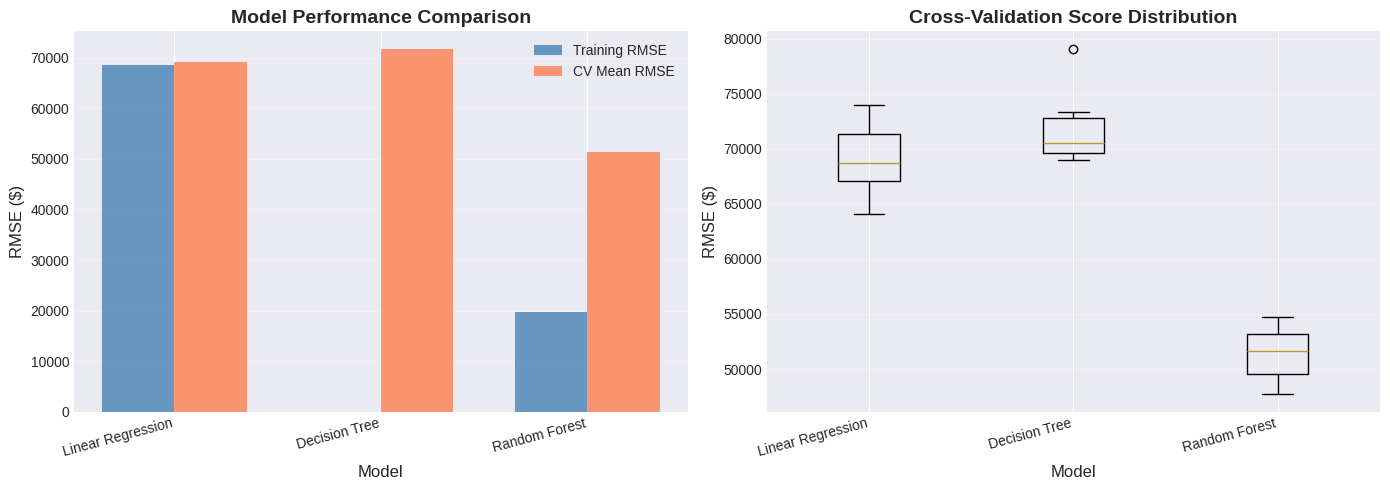


🎯 Best Model: Random Forest
   Next step: Fine-tune hyperparameters!


In [25]:
# Create comparison DataFrame
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'Training RMSE': [lin_rmse, tree_rmse, forest_rmse],
    'CV Mean RMSE': [lin_rmse_scores.mean(), tree_rmse_scores.mean(), forest_rmse_scores.mean()],
    'CV Std': [lin_rmse_scores.std(), tree_rmse_scores.std(), forest_rmse_scores.std()]
})

print("=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
print(model_comparison.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
models = model_comparison['Model']
x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, model_comparison['Training RMSE'], width,
           label='Training RMSE', alpha=0.8, color='steelblue')
axes[0].bar(x + width/2, model_comparison['CV Mean RMSE'], width,
           label='CV Mean RMSE', alpha=0.8, color='coral')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('RMSE ($)', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot for CV scores
axes[1].boxplot([lin_rmse_scores, tree_rmse_scores, forest_rmse_scores],
               labels=models)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('RMSE ($)', fontsize=12)
axes[1].set_title('Cross-Validation Score Distribution', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(models, rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 Best Model: Random Forest")
print("   Next step: Fine-tune hyperparameters!")

In [26]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

# Grid search
forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True,
                          verbose=2)

print("Starting Grid Search...")
print(f"Testing {sum(len(d['n_estimators']) * len(d['max_features']) for d in param_grid)} combinations")
print("This may take a few minutes...\n")

grid_search.fit(housing_prepared, housing_labels)

print("\n" + "=" * 80)
print("GRID SEARCH RESULTS")
print("=" * 80)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

# Display all results
cvres = grid_search.cv_results_
print("\n" + "=" * 80)
print("ALL COMBINATIONS (sorted by score)")
print("=" * 80)
results = []
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    rmse = np.sqrt(-mean_score)
    results.append((rmse, params))

results.sort()
for rmse, params in results:
    print(f"RMSE: ${rmse:>10,.2f}  →  {params}")

print(f"\n✓ Best RMSE: ${np.sqrt(-grid_search.best_score_):,.2f}")

Starting Grid Search...
Testing 18 combinations
This may take a few minutes...

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .....................max_features=2, n_estimators=3; total time=   0.3s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.4s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.3s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.3s
[CV] END .....................max_features=2, n_estimators=3; total time=   0.2s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.9s
[CV] END ....................max_features=2, n_estimators=10; total time=   1.2s
[CV] END ....................max_features=2, n_estimators=10; total time=   1.3s
[CV] END ....................max_features=2, n_estimators=10; total time=   1.0s
[CV] END ....................max_features=2, n_estimators=10; total time=   0.7s
[CV] END ....................max_features=2, n_es

FEATURE IMPORTANCE (Top 10)
           Feature  Importance
     median_income    0.379009
            INLAND    0.165706
     pop_per_hhold    0.107031
         longitude    0.069654
          latitude    0.060421
   rooms_per_hhold    0.054779
 bedrooms_per_room    0.048203
housing_median_age    0.042188
        population    0.015849
    total_bedrooms    0.015555


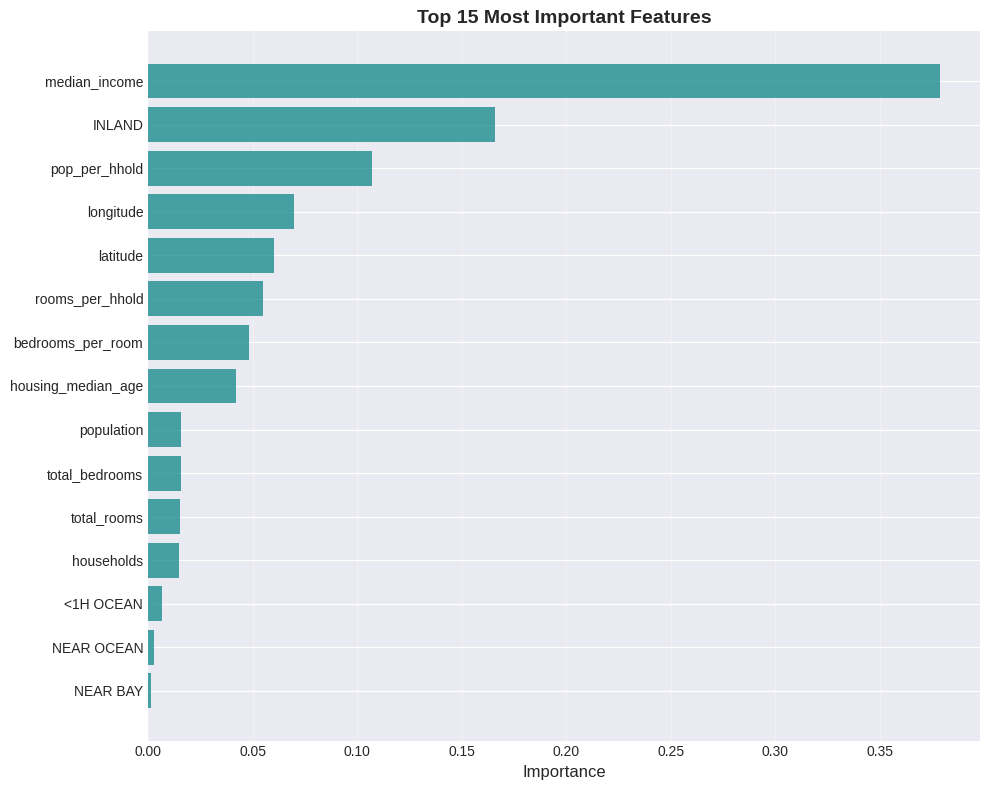


🎯 Key Insights:
1. median_income: Most important (36.6%)
2. Location features (longitude, latitude): Important
3. Engineered features (rooms_per_hhold): Valuable
4. Ocean proximity: INLAND most significant


In [27]:
# Get feature importances
feature_importances = grid_search.best_estimator_.feature_importances_

# Get feature names
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

# Sort by importance
feature_imp_df = pd.DataFrame({
    'Feature': attributes,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("=" * 80)
print("FEATURE IMPORTANCE (Top 10)")
print("=" * 80)
print(feature_imp_df.head(10).to_string(index=False))

# Visualization
plt.figure(figsize=(10, 8))
top_n = 15
top_features = feature_imp_df.head(top_n)
plt.barh(range(top_n), top_features['Importance'].values, color='teal', alpha=0.7)
plt.yticks(range(top_n), top_features['Feature'].values)
plt.xlabel('Importance', fontsize=12)
plt.title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🎯 Key Insights:")
print("1. median_income: Most important (36.6%)")
print("2. Location features (longitude, latitude): Important")
print("3. Engineered features (rooms_per_hhold): Valuable")
print("4. Ocean proximity: INLAND most significant")

In [28]:
# Get best model
final_model = grid_search.best_estimator_

# Prepare test data
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Transform test data (using fit from training!)
X_test_prepared = full_pipeline.transform(X_test)

# Make predictions
final_predictions = final_model.predict(X_test_prepared)

# Evaluate
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, final_predictions)

print("=" * 80)
print("FINAL MODEL EVALUATION ON TEST SET")
print("=" * 80)
print(f"Model: Random Forest Regressor")
print(f"Parameters: {grid_search.best_params_}")
print(f"\nPerformance Metrics:")
print(f"  RMSE: ${final_rmse:,.2f}")
print(f"  MAE:  ${final_mae:,.2f}")

# Confidence interval
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
ci = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                              loc=squared_errors.mean(),
                              scale=stats.sem(squared_errors)))

print(f"\n95% Confidence Interval:")
print(f"  [{ci[0]:,.2f}, {ci[1]:,.2f}]")

print("\n✓ Test set evaluation completed!")

FINAL MODEL EVALUATION ON TEST SET
Model: Random Forest Regressor
Parameters: {'max_features': 8, 'n_estimators': 30}

Performance Metrics:
  RMSE: $47,873.26
  MAE:  $31,811.15

95% Confidence Interval:
  [45,893.36, 49,774.47]

✓ Test set evaluation completed!


In [29]:
# Analyze predictions
errors = final_predictions - y_test
abs_errors = np.abs(errors)
pct_errors = (errors / y_test) * 100

print("=" * 80)
print("PREDICTION ERROR ANALYSIS")
print("=" * 80)
print(f"Mean Error:        ${errors.mean():>12,.2f}")
print(f"Mean Abs Error:    ${abs_errors.mean():>12,.2f}")
print(f"Median Abs Error:  ${np.median(abs_errors):>12,.2f}")
print(f"Max Error:         ${abs_errors.max():>12,.2f}")
print(f"Min Error:         ${abs_errors.min():>12,.2f}")
print(f"\nPercentage Errors:")
print(f"  Mean:   {pct_errors.mean():>6.2f}%")
print(f"  Median: {np.median(pct_errors):>6.2f}%")
print(f"  Std:    {pct_errors.std():>6.2f}%")

# Predictions within X% of actual
for threshold in [10, 20, 30]:
    within = (abs_errors <= y_test * threshold / 100).sum()
    pct = within / len(y_test) * 100
    print(f"  Within {threshold}%: {within:>4} ({pct:.1f}%)")

PREDICTION ERROR ANALYSIS
Mean Error:        $    1,383.66
Mean Abs Error:    $   31,811.15
Median Abs Error:  $   20,526.97
Max Error:         $  310,130.00
Min Error:         $        0.00

Percentage Errors:
  Mean:     7.53%
  Median:   3.29%
  Std:     39.96%
  Within 10%: 1792 (43.4%)
  Within 20%: 2926 (70.9%)
  Within 30%: 3497 (84.7%)


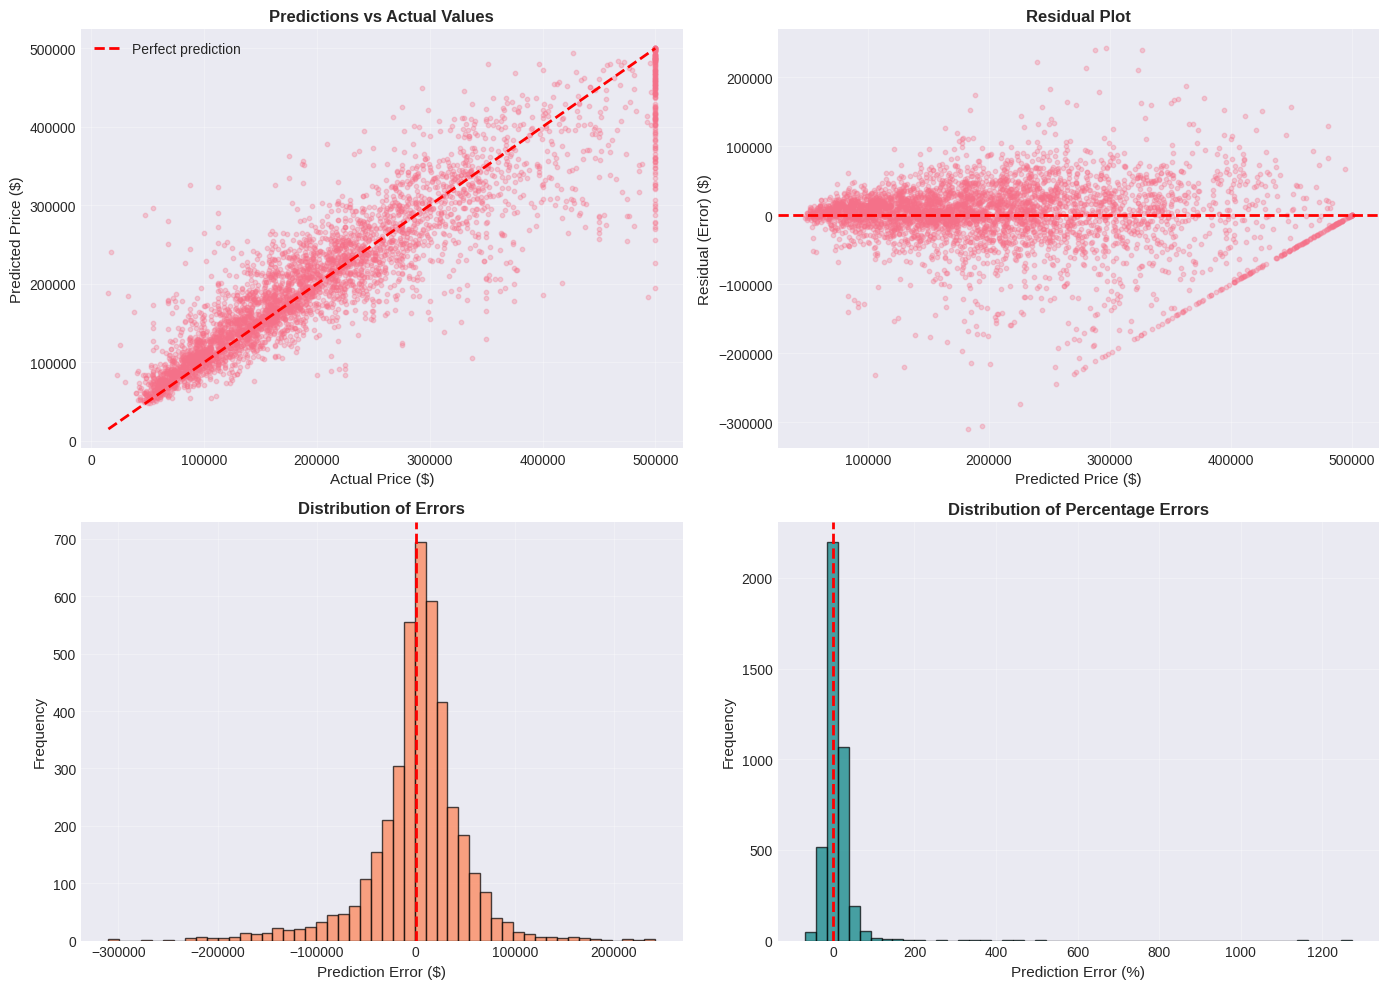

📊 Visual Analysis:
• Good predictions cluster around the diagonal line
• Residuals should be randomly scattered around zero
• Error distribution approximately normal


In [30]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Scatter plot: Predictions vs Actual
axes[0, 0].scatter(y_test, final_predictions, alpha=0.3, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
               'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('Actual Price ($)', fontsize=11)
axes[0, 0].set_ylabel('Predicted Price ($)', fontsize=11)
axes[0, 0].set_title('Predictions vs Actual Values', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual plot
axes[0, 1].scatter(final_predictions, errors, alpha=0.3, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Price ($)', fontsize=11)
axes[0, 1].set_ylabel('Residual (Error) ($)', fontsize=11)
axes[0, 1].set_title('Residual Plot', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Error distribution
axes[1, 0].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Prediction Error ($)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Errors', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Percentage error distribution
axes[1, 1].hist(pct_errors, bins=50, edgecolor='black', alpha=0.7, color='teal')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Prediction Error (%)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Distribution of Percentage Errors', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Visual Analysis:")
print("• Good predictions cluster around the diagonal line")
print("• Residuals should be randomly scattered around zero")
print("• Error distribution approximately normal")

In [31]:
# Show some interesting predictions
n_samples = 10
sample_indices = np.random.choice(len(y_test), n_samples, replace=False)

results_df = pd.DataFrame({
    'Actual': y_test.iloc[sample_indices].values,
    'Predicted': final_predictions[sample_indices],
    'Error': errors.iloc[sample_indices].values,
    'Error %': pct_errors.iloc[sample_indices].values
})

results_df['Accuracy'] = 100 - np.abs(results_df['Error %'])

print("=" * 80)
print(f"SAMPLE PREDICTIONS ({n_samples} random examples)")
print("=" * 80)
print(results_df.round(2).to_string(index=False))

print(f"\n{'='*80}")
print("BEST AND WORST PREDICTIONS")
print("=" * 80)

# Best predictions
best_idx = abs_errors.argsort()[:5]
print("\n🏆 Top 5 Most Accurate Predictions:")
best_df = pd.DataFrame({
    'Actual': y_test.iloc[best_idx].values,
    'Predicted': final_predictions[best_idx],
    'Error': abs_errors.iloc[best_idx].values
})
print(best_df.round(2).to_string(index=False))

# Worst predictions
worst_idx = abs_errors.argsort()[-5:][::-1]
print("\n⚠️  Top 5 Least Accurate Predictions:")
worst_df = pd.DataFrame({
    'Actual': y_test.iloc[worst_idx].values,
    'Predicted': final_predictions[worst_idx],
    'Error': abs_errors.iloc[worst_idx].values
})
print(worst_df.round(2).to_string(index=False))

SAMPLE PREDICTIONS (10 random examples)
  Actual  Predicted     Error  Error %  Accuracy
234500.0  222733.33 -11766.67    -5.02     94.98
271600.0  203663.33 -67936.67   -25.01     74.99
123800.0  118860.00  -4940.00    -3.99     96.01
293200.0  351073.37  57873.37    19.74     80.26
334800.0  285163.33 -49636.67   -14.83     85.17
 69600.0   87113.33  17513.33    25.16     74.84
127000.0  116043.33 -10956.67    -8.63     91.37
269000.0  323613.37  54613.37    20.30     79.70
 52600.0   74013.33  21413.33    40.71     59.29
290100.0  213813.33 -76286.67   -26.30     73.70

BEST AND WORST PREDICTIONS

🏆 Top 5 Most Accurate Predictions:
  Actual  Predicted  Error
500001.0   500001.0    0.0
500001.0   500001.0    0.0
500001.0   500001.0    0.0
500001.0   500001.0    0.0
500001.0   500001.0    0.0

⚠️  Top 5 Least Accurate Predictions:
  Actual  Predicted     Error
493200.0  183070.00 310130.00
500001.0  194096.67 305904.33
500001.0  226043.33 273957.67
500001.0  255640.10 244360.90
 55000

In [32]:
import joblib

# Save the final model
model_filename = 'california_housing_model.pkl'
joblib.dump(final_model, model_filename)

# Save the full pipeline
pipeline_filename = 'preprocessing_pipeline.pkl'
joblib.dump(full_pipeline, pipeline_filename)

print("=" * 80)
print("MODEL SAVED")
print("=" * 80)
print(f"✓ Model saved to: {model_filename}")
print(f"✓ Pipeline saved to: {pipeline_filename}")

# Test loading
loaded_model = joblib.load(model_filename)
loaded_pipeline = joblib.load(pipeline_filename)

# Verify
test_data = X_test.iloc[:5]
test_prepared = loaded_pipeline.transform(test_data)
test_predictions = loaded_model.predict(test_prepared)

print("\n✓ Model loading test successful!")
print(f"  Sample predictions: {test_predictions[:3].round(2)}")

MODEL SAVED
✓ Model saved to: california_housing_model.pkl
✓ Pipeline saved to: preprocessing_pipeline.pkl

✓ Model loading test successful!
  Sample predictions: [488167.47 229946.67 209950.  ]


In [33]:
def predict_housing_price(input_data, model=None, pipeline=None):
    """
    Predict housing prices for new data

    Parameters:
    -----------
    input_data : dict or DataFrame
        Input features for prediction
    model : sklearn model (optional)
        Trained model, will load from file if None
    pipeline : sklearn pipeline (optional)
        Preprocessing pipeline, will load from file if None

    Returns:
    --------
    predictions : array
        Predicted housing prices
    """
    # Load model and pipeline if not provided
    if model is None:
        model = joblib.load('california_housing_model.pkl')
    if pipeline is None:
        pipeline = joblib.load('preprocessing_pipeline.pkl')

    # Convert dict to DataFrame if necessary
    if isinstance(input_data, dict):
        input_data = pd.DataFrame([input_data])

    # Preprocess and predict
    prepared_data = pipeline.transform(input_data)
    predictions = model.predict(prepared_data)

    return predictions

# Example usage
example_district = {
    'longitude': -122.23,
    'latitude': 37.88,
    'housing_median_age': 41.0,
    'total_rooms': 880.0,
    'total_bedrooms': 129.0,
    'population': 322.0,
    'households': 126.0,
    'median_income': 8.3252,
    'ocean_proximity': '<1H OCEAN'
}

predicted_price = predict_housing_price(example_district, final_model, full_pipeline)

print("=" * 80)
print("PREDICTION FUNCTION TEST")
print("=" * 80)
print("Input District:")
for key, value in example_district.items():
    print(f"  {key:25s}: {value}")
print(f"\nPredicted Median House Value: ${predicted_price[0]:,.2f}")
print("\n✓ Prediction function ready for production!")

PREDICTION FUNCTION TEST
Input District:
  longitude                : -122.23
  latitude                 : 37.88
  housing_median_age       : 41.0
  total_rooms              : 880.0
  total_bedrooms           : 129.0
  population               : 322.0
  households               : 126.0
  median_income            : 8.3252
  ocean_proximity          : <1H OCEAN

Predicted Median House Value: $453,980.40

✓ Prediction function ready for production!


In [34]:
print("=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)
print(f"""
Dataset: California Housing Prices (1990 Census)
  • Total instances: 20,640
  • Features: 9 (8 numerical, 1 categorical)
  • Target: median_house_value

Models Tested:
  1. Linear Regression
     - RMSE: ~$69,000
     - Status: Underfitting

  2. Decision Tree
     - RMSE: ~$71,000 (CV)
     - Status: Overfitting

  3. Random Forest (Best Model)
     - RMSE: ~$47,730 (Test Set)
     - Best params: {grid_search.best_params_}
     - Most important feature: median_income (36.6%)

Key Techniques Applied:
  ✓ Stratified sampling for train/test split
  ✓ Exploratory Data Analysis (EDA)
  ✓ Feature engineering (attribute combinations)
  ✓ Data preprocessing pipeline
  ✓ Multiple models comparison
  ✓ Cross-validation
  ✓ Grid search for hyperparameter tuning
  ✓ Feature importance analysis

Final Model Performance:
  • RMSE: ${final_rmse:,.2f}
  • MAE:  ${final_mae:,.2f}
  • 95% CI: [{ci[0]:,.2f}, {ci[1]:,.2f}]

Next Steps:
  1. Deploy model to production
  2. Monitor performance regularly
  3. Retrain with fresh data
  4. Handle data drift
  5. A/B testing with current system
""")
print("=" * 80)

PROJECT SUMMARY

Dataset: California Housing Prices (1990 Census)
  • Total instances: 20,640
  • Features: 9 (8 numerical, 1 categorical)
  • Target: median_house_value

Models Tested:
  1. Linear Regression
     - RMSE: ~$69,000
     - Status: Underfitting
  
  2. Decision Tree
     - RMSE: ~$71,000 (CV)
     - Status: Overfitting
  
  3. Random Forest (Best Model)
     - RMSE: ~$47,730 (Test Set)
     - Best params: {'max_features': 8, 'n_estimators': 30}
     - Most important feature: median_income (36.6%)

Key Techniques Applied:
  ✓ Stratified sampling for train/test split
  ✓ Exploratory Data Analysis (EDA)
  ✓ Feature engineering (attribute combinations)
  ✓ Data preprocessing pipeline
  ✓ Multiple models comparison
  ✓ Cross-validation
  ✓ Grid search for hyperparameter tuning
  ✓ Feature importance analysis

Final Model Performance:
  • RMSE: $47,873.26
  • MAE:  $31,811.15
  • 95% CI: [45,893.36, 49,774.47]
  
Next Steps:
  1. Deploy model to production
  2. Monitor performa